<a href="https://colab.research.google.com/github/DAI3862/DNN/blob/main/Day12/Fashion_CNN_from_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import tensorflow as tf
import seaborn as sns

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [ ]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'weather'
altName = 'tf_cnn'
logDir = './logs'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE)
EPOCHS = 50 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

REG_LAMBDA = 0.001
PATIENCE = 20 # EarlyStopping -> If n no. of epochs give similar o/p, then it will stop the execution
LR_PATIENCE = 10
LR_FACTOR = 0.1

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [ ]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

Prepare Data

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [ ]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

<Axes: xlabel='label'>

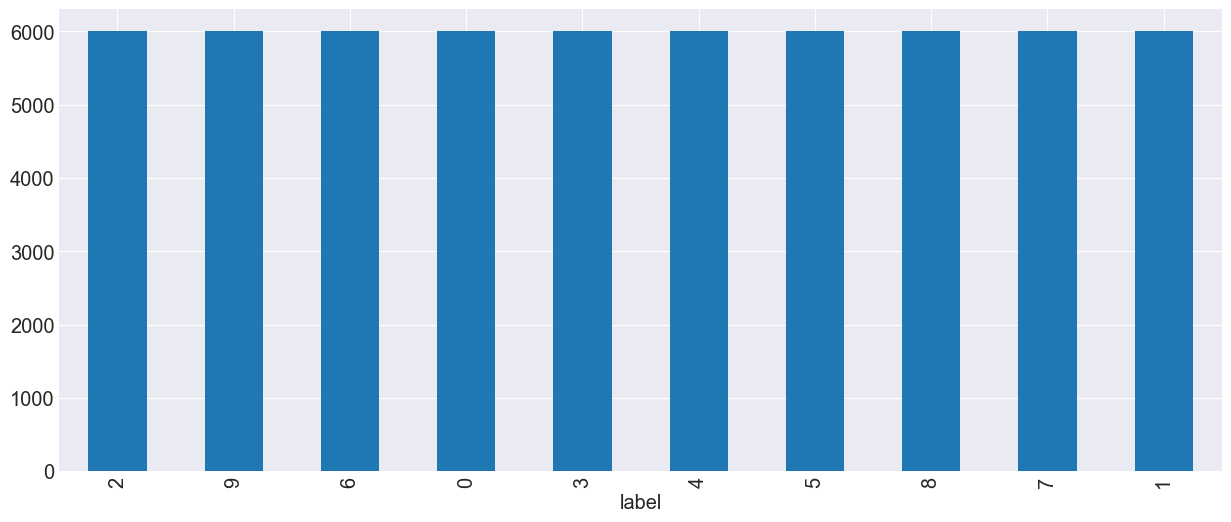

In [ ]:
train_df['label'].value_counts().plot(kind='bar')

<Axes: xlabel='label'>

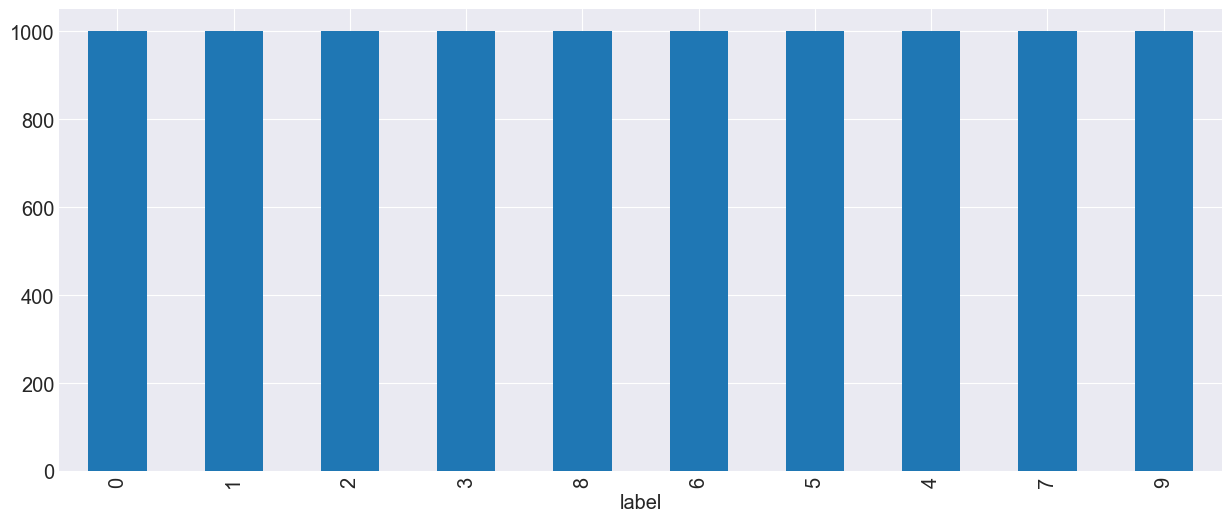

In [ ]:
test_df['label'].value_counts().plot(kind='bar')

In [ ]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [ ]:
def split_features_label(row):

    feature = tf.reshape(row[1:], [28,28,1])

    label = row[0]

    return feature, label

In [ ]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_features_label)

train_ds = train_ds.batch(BATCH_SIZE)

In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

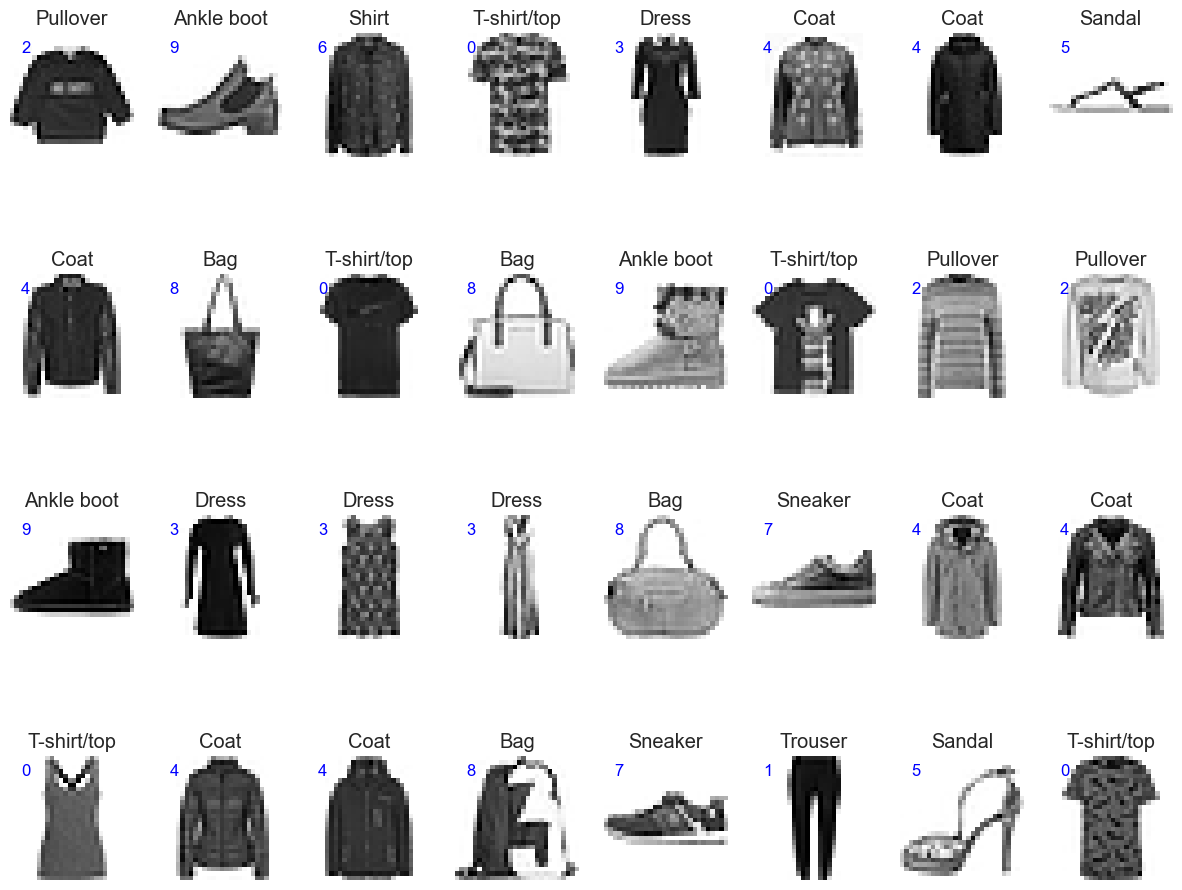

In [ ]:
fig = plt.figure(figsize=(15, 12))  # figure size in inches

for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):

        plt.subplot(4, int(BATCH_SIZE//4), i+1)

        plt.imshow(images[i].numpy().astype('uint16'), cmap=plt.cm.binary, interpolation='nearest') # show image on the axis

        plt.title(class_names[labels[i].numpy()])   # add number (class) of the image

        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image

        plt.axis('off')

plt.show()

In [ ]:
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_features_label)

test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
test_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

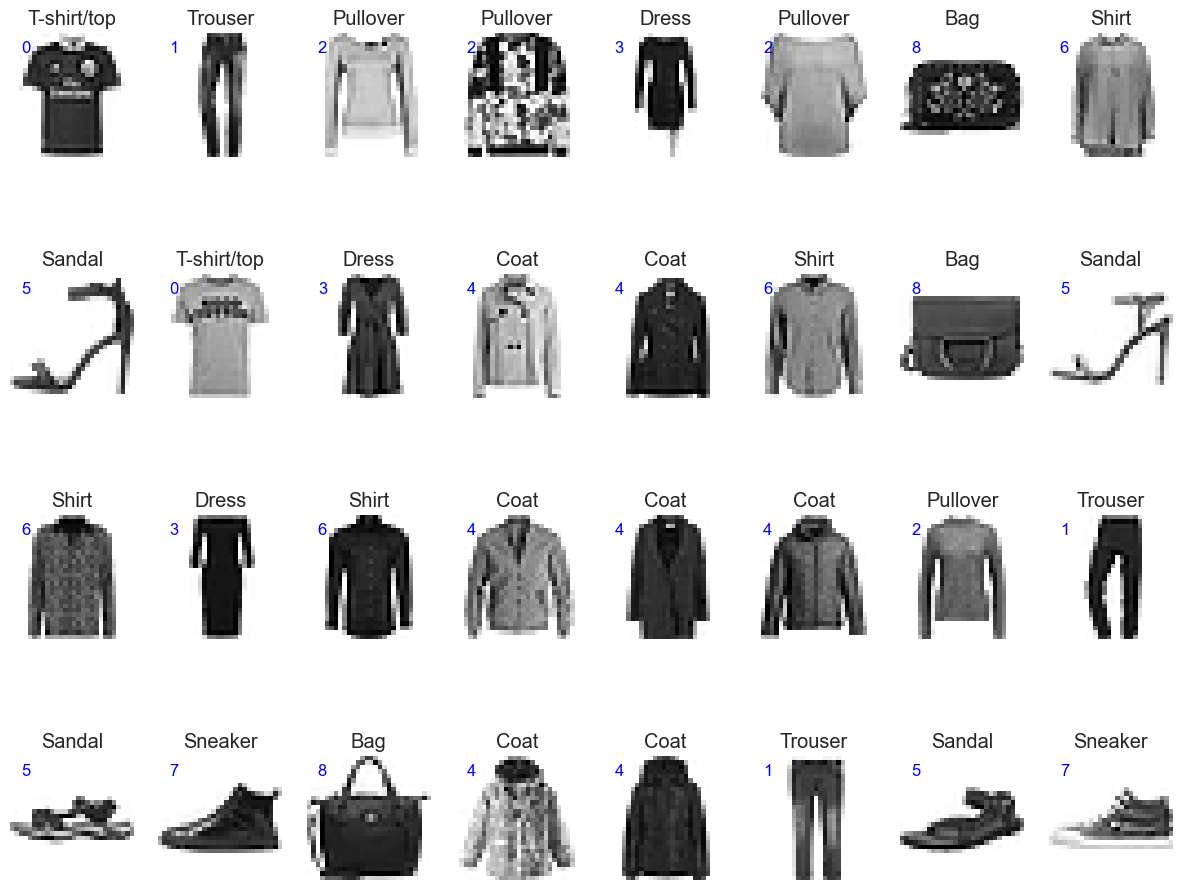

In [ ]:
fig = plt.figure(figsize=(15, 12))  # figure size in inches

for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):

        plt.subplot(4, int(BATCH_SIZE//4), i+1)

        plt.imshow(images[i].numpy().astype('uint16'), cmap=plt.cm.binary, interpolation='nearest') # show image on the axis

        plt.title(class_names[labels[i].numpy()])   # add number (class) of the image

        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image

        plt.axis('off')

plt.show()

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size= tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size= tf.data.AUTOTUNE)

In Subsequent copies, delete these lines

In [ ]:
norm_layers = tf.keras.layers.Rescaling(1./255.)

images, labels = next(iter(train_ds))

img = images[0].numpy()

print(img.max(), img.min())

#--------------------
norm_ds = train_ds.map(lambda x,y: (norm_layers(x), y))

images, labels = next(iter(norm_ds))

img = images[0].numpy()

print(img.max(), img.min())


255 0
1.0 0.0


### Convolution Layer

In [ ]:
input_shape = (1, 6, 6, 1) # batch * h * w * c

X = tf.random.normal(input_shape)

In [ ]:
# Reshape the slice of X to be 1D
x_values = X.numpy()[2:3].flatten()
y_values = X.numpy()[3:4].flatten()

plt.plot(x_values, y_values)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Random Data Plot')
plt.show()

<Axes: >

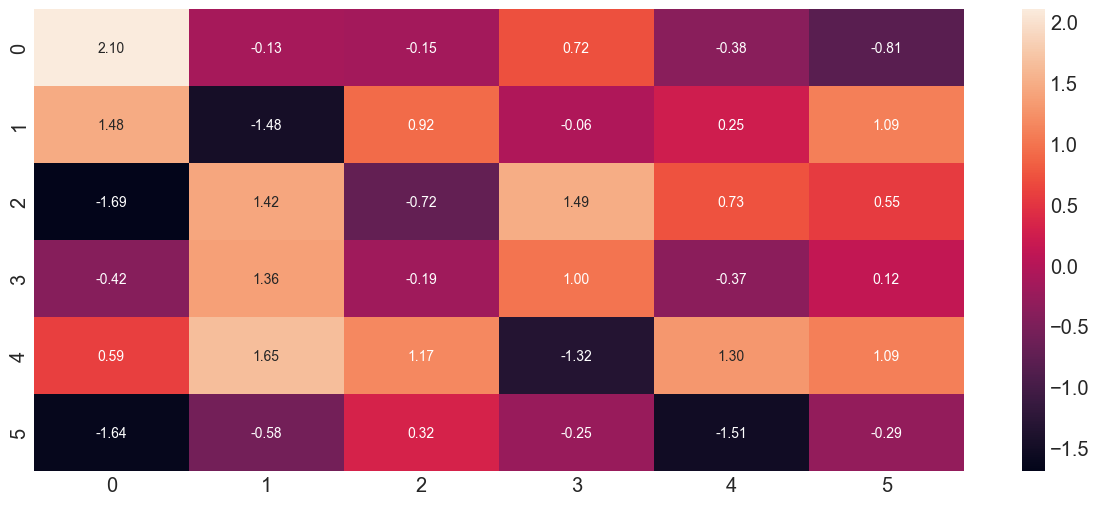

In [ ]:
sns.heatmap(X.numpy()[0, :, :, 0], annot= True, fmt= '.2f')

In [ ]:
tf.keras.layers.Conv2D?

Init signature:
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Docstring:     
2D convolution layer (e.g. spatial convolution over images).

This layer creates a convolution kernel that is convolved
with the layer input to produce a tensor of
outputs. If `use_bias` is True,
a bias vector is created and added to the outputs. Finally, if
`activation` is not `None`, it is applied to the outputs as well.

When using this layer as the first layer in a model,
provide the keyword argument `input_shape`
(tuple of integers or `None`, does not include the sample axis),
e.g. `input_shape=(128, 128, 3)` for 128x128 RGB picture

In [ ]:
input_shape[1:]

(6, 6, 1)

In [ ]:
y = tf.keras.layers.Conv2D(1, 3,
                           kernel_initializer = tf.constant_initializer(1.),
                           use_bias = False,
                           activation = 'relu',
                           input_shape = input_shape[1:])(X)

y.shape

TensorShape([1, 4, 4, 1])

<Axes: >

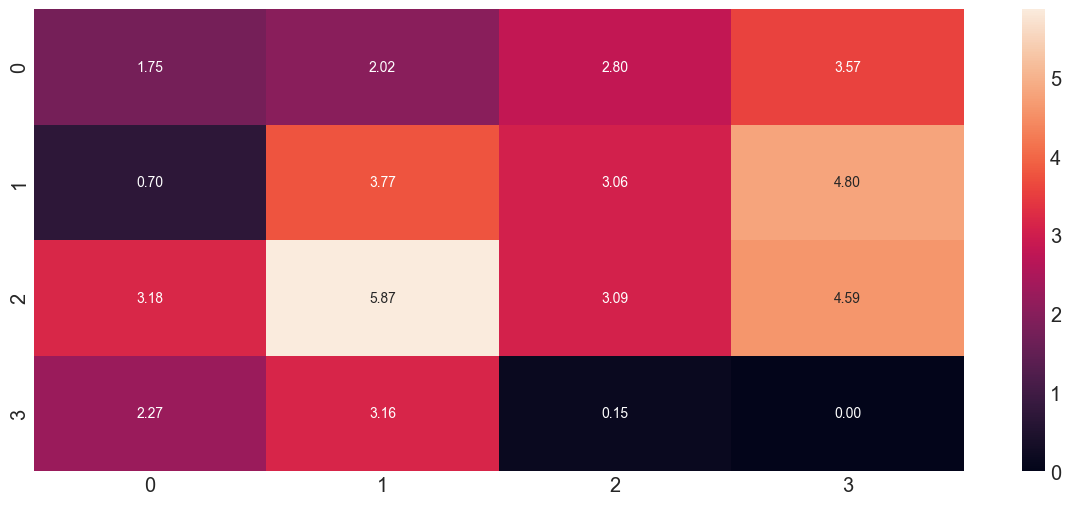

In [ ]:
sns.heatmap(y.numpy()[0, :, :, 0], annot= True, fmt= '.2f')

<Axes: >

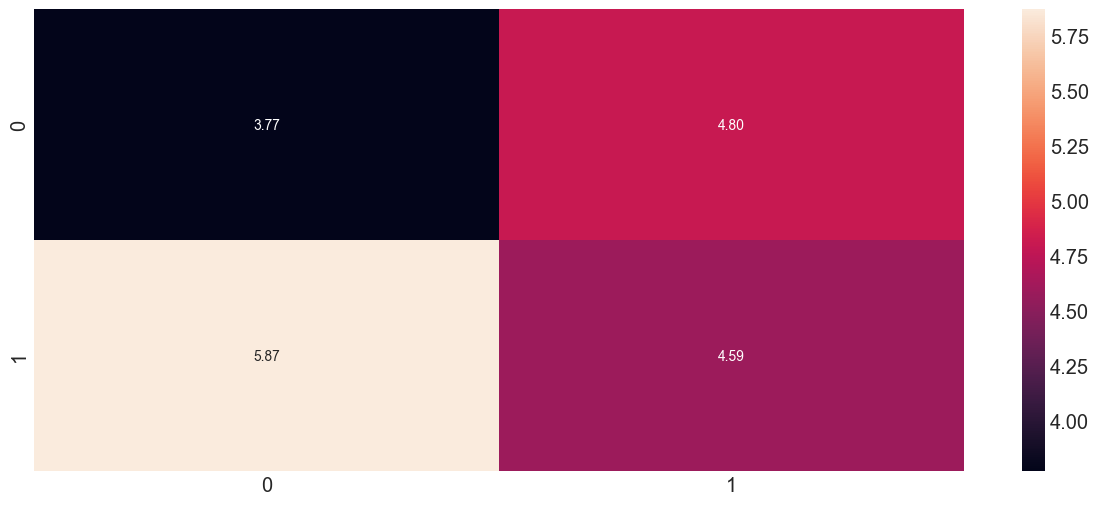

In [ ]:
max_pool_layer = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                           strides= (2,2),
                                           padding= 'valid')

Z = max_pool_layer(y)

sns.heatmap(Z.numpy()[0, :, :, 0], annot= True, fmt= '.2f')

In [ ]:
reg_lambda = 0.005

knl_reg = tf.keras.regularizers.L2(reg_lambda)
# L2 is weight Decay, so we need to specify it in every layer[convolution and dense] except the output

model = tf.keras.Sequential()

# Pre-processing
model.add(tf.keras.layers.Rescaling(1./255.))

####
# Set 1
####
model.add(tf.keras.layers.Conv2D(
    32, 3, # filters = 32; kernel_size = 3
    padding='same',
    kernel_regularizer = knl_reg,
    activation= 'relu',
    input_shape = (28, 28, 1)
    )) # o/p: 28 x 28 x 32

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 14 x 14 x 32

####
# Set 2
####
model.add(tf.keras.layers.Conv2D(
    64, 3, # filters = 64; kernel_size = 3
    padding='valid',
    kernel_regularizer = knl_reg,
    activation= 'relu'
    )) # o/p: 12 x 12 x 64

model.add(tf.keras.layers.MaxPool2D()) # 6 x 6 x 64

####
# Set 3
####
model.add(tf.keras.layers.Conv2D(
    128, 3, # filters = 128; kernel_size = 3
    padding='valid',
    kernel_regularizer = knl_reg,
    activation= 'relu'
    )) # o/p: 4 x 4 x 128


### Head

In [ ]:
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = knl_reg))

model.add(tf.keras.layers.Dense(10))

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(loss= loss_fn,
              optimizer= 'adam',
              metrics=['accuracy'])

In [ ]:
checkpoint_path = os.path.join(modelDir, subDir, 'weights_tf_fashion')

model_ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto' # how to track the monitoring -> auto = autoset;
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # min_delta=0, It defines for how many decimal places we want to be considered the monitor value
    patience=PATIENCE,
    verbose=2,
    mode='auto',
    restore_best_weights=True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_lr=0.00001
)


log_dir = os.path.join(logDir, 'fit')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq =1)

In [ ]:
history = model.fit(train_ds,
                    epochs= EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [model_ckpt_callback,
                                 es_callback,
                                 lr_callback,
                                 tb_callback],
                    verbose= 2,
                    validation_data=test_ds)

Epoch 1/50



Epoch 1: val_loss improved from inf to 0.62438, saving model to ./models\weather\weights_tf_fashion
1875/1875 - 23s - loss: 0.8161 - accuracy: 0.7916 - val_loss: 0.6244 - val_accuracy: 0.8484 - lr: 0.0010 - 23s/epoch - 12ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.62438 to 0.57362, saving model to ./models\weather\weights_tf_fashion
1875/1875 - 21s - loss: 0.6082 - accuracy: 0.8437 - val_loss: 0.5736 - val_accuracy: 0.8561 - lr: 0.0010 - 21s/epoch - 11ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.57362 to 0.54943, saving model to ./models\weather\weights_tf_fashion
1875/1875 - 21s - loss: 0.5667 - accuracy: 0.8542 - val_loss: 0.5494 - val_accuracy: 0.8588 - lr: 0.0010 - 21s/epoch - 11ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.54943 to 0.53404, saving model to ./models\weather\weights_tf_fashion
1875/1875 - 21s - loss: 0.5442 - accuracy: 0.8602 - val_loss: 0.5340 - val_accuracy: 0.8619 - lr: 0.0010 - 21s/epoch - 11ms/step
Epoch 5/50

Epoch 5: v

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         7

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.816103,0.791617,0.624376,0.8484,0.001
1,0.608221,0.843733,0.573617,0.8561,0.001
2,0.566676,0.854200,0.549432,0.8588,0.001
3,0.544162,0.860217,0.534035,0.8619,0.001
4,0.528340,0.863467,0.518347,0.8632,0.001


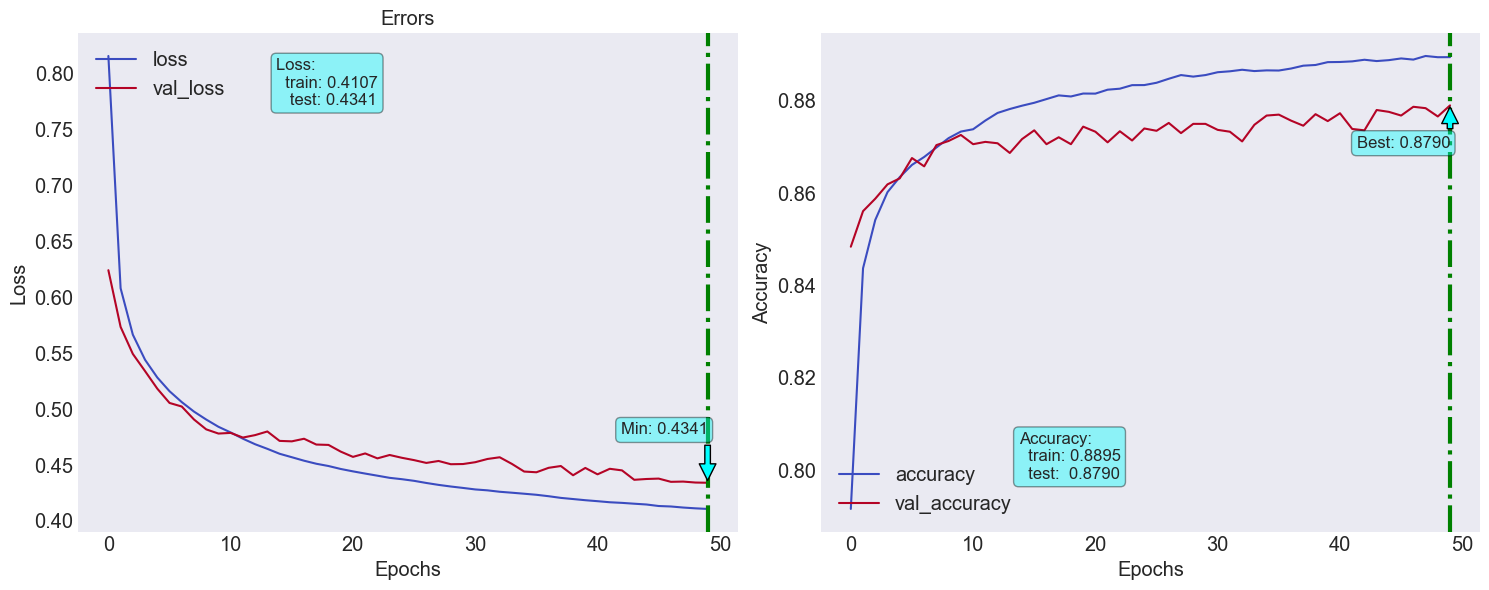

In [ ]:
fn_plot_tf_hist(loss_df)

|params|Img|
|-----|-----|
|Base| ![image.png](attachment:image.png)|
|L2, reg_lambda = 0.005, epochs 50|![image-2.png](attachment:image-2.png)|
|L2, reg_lambda = 0.005, epochs 100|![image-3.png](attachment:image-3.png)|